# Rozpoznawanie rasy psów

## 1. Przygotowanie danych

### **1.1. Importowanie pakietów**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import PIL.Image
from IPython.display import display

import pandas as pd

from zipfile import ZipFile
from io import BytesIO

### **1.2. Rozpakowywanie plików**

In [2]:
#Rozpakowanie zbioru trenującego oraz testowego
archive_train = ZipFile("../Data/train.zip", 'r')
archive_test = ZipFile("../Data/test.zip", 'r')

#Wyświetlenie liczby zdjęć w zbiorze trenującym
len(archive_train.namelist()[:])-1 

10222

### **1.3. Zmiana rozmiaru oraz normalizacja danych**

In [3]:
# Utrzoenie pickle przechowującego wszystkie zdjęcia z zip'a
###############
def DataBase_creator(archivezip, nwigth, nheight, save_name):
    
    s = (len(archivezip.namelist()[:])-1, nwigth, nheight,3) 
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwigth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
        
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )

In [4]:
# Nowy rozmiar dla zdjęć
image_resize = 60

In [5]:
# Dodanie zdjęć ze zbioru trenująćego
DataBase_creator(archivezip = archive_train, nwigth = image_resize, nheight = image_resize , save_name = "train")

In [6]:
# Dodanie zdjęć ze zbioru testowego
DataBase_creator(archivezip = archive_test, nwigth = image_resize, nheight = image_resize , save_name = "test")

In [7]:
# Wczytanie zbioru trenującego
train = pickle.load( open( "train.p", "rb" ) )
train.shape

(10222, 60, 60, 3)

In [8]:
# Wczytanie zbioru testowego
test = pickle.load( open( "test.p", "rb" ) )
test.shape

(10357, 60, 60, 3)

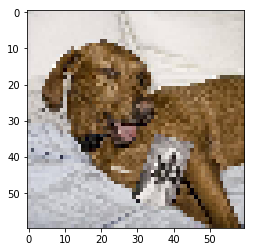

In [9]:
# Wyświetlenie przykładowego zdjęcia 
lum_img = train[100,:,:,:]
plt.imshow(lum_img)
plt.show()

### **1.4. Wczytanie etykiet**

In [10]:
labels_raw = pd.read_csv("../Data/labels.csv", header=0, sep=',', quotechar='"')

# Wyświetlenie pięciu losowych etykiet
labels_raw.sample(5)

,id,breed
7326,b7831e4626212d1b11d5a98c9eaeabdb,irish_terrier
9446,ece92625596397f614310352584d7b74,west_highland_white_terrier
2591,405e14a091434aeca10fdaaad56dca8d,brittany_spaniel
3024,4acfbe200ca3a0f7530ec6387b73210b,basset
6364,a064e19920ce6da2dd7cca371ff9efd4,bernese_mountain_dog


### **1.5. Wyodrębnienie N najbardziej licznych ras psów**

In [11]:
# Liczba ras psów do wyodrębnienia
Nber_of_breeds = 2

In [12]:
# Wydorębnienie N ras psów
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 2 main breeds : (243,)
- The shape of train_filtered dataset is : (243, 60, 60, 3)


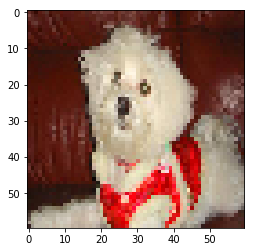

In [13]:
# Wyświetlenie pierwszego zdjęcia
lum_img = train_filtered[1,:,:,:]
plt.imshow(lum_img)
plt.show()

### **1.6. Utworzenie One-hot labels**

In [14]:
# Wyodrębnienie etykiet dla N ras psów 
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) 
labels.shape

(243, 1)

In [15]:
#Function to breate one-hot labels 
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)
            
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [16]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Shape : (243, 2)


array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])

### **1.7. Sprawdzenie etykiet**

In [17]:
# Wyświetlenie nazw N ras psów
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : maltese_dog
Breed 1 : scottish_deerhound


In [18]:
labels[0:9]

array([['scottish_deerhound'],
       ['maltese_dog'],
       ['scottish_deerhound'],
       ['maltese_dog'],
       ['scottish_deerhound'],
       ['maltese_dog'],
       ['maltese_dog'],
       ['scottish_deerhound'],
       ['scottish_deerhound']], dtype=object)

In [19]:
labels_cls = np.argmax(labels_bin, axis=1)
labels_name[labels_cls[2]]

'scottish_deerhound'

scottish_deerhound


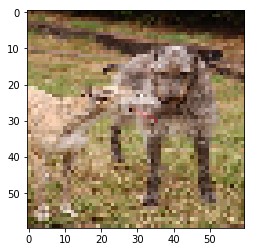

In [20]:
# Wyświetlenie przykładowego zdjęcia wraz z etykietą
i=11
print(labels_name[labels_cls[i]])
lum_img = train_filtered[i,:,:,:]
plt.imshow(lum_img)
plt.show()

## **2. Utworzenie konwolucyjen sieci neuronowej**

### **2.1. Utworzenie zbioru trenującego oraz walidacyjnego**




In [21]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)
print("Train {0}".format(X_train.shape))
print("Test {0}".format(X_validation.shape))

Train (170, 60, 60, 3)
Test (73, 60, 60, 3)


In [22]:
#fZnalezienie rasy psa z one-hot label
df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

maltese_dog
0


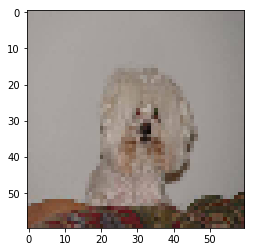

In [23]:
# Sprawdzenie utworzonej tablicy
i=2
print(labels_name[df_validation_toPred_cls[i]])
print(df_validation_toPred_cls[i])
lum_img = X_validation[i,:,:,:]
plt.imshow(lum_img)
plt.show()

### **2.2. Definicja warstw**

- Warstwa konwolucyjna n°1 z 32 filtrami
 + Max pooling
 + Relu
- Warstwa konwolucyjna n°2 z 64 filtrami
 + Max pooling
 + Relu
- Warstwa konwolucyjna n°3 z 128 filtrami
 + Max pooling
 + Relu
 + DropOut
- Flatten Layer
- W pełni połączona warstwa z 500 neuronami
  + Relu
  + DropOut
- W pełni połączona warstwa z n neuronami (n = liczba ras psów)

In [24]:
# Our images are 100 pixels in each dimension.
img_size = image_resize
# Liczba kanałów dla koloru RGB
num_channels = 3
# Rozmiar zdjęcia 
img_size_flat = img_size * img_size
# Wymiary zdjęcia
img_shape = (img_size, img_size, num_channels)
# Liczba ras psów
num_classes = Nber_of_breeds

In [25]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [26]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True,
                   use_dropout=True): 
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    return layer, weights

In [27]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [28]:
def new_fc_layer(input,          
                 num_inputs,    
                 num_outputs,   
                 use_relu=True,
                 use_dropout=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

### **2.3. Konfiguracja placeholder**

In [29]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

### **2.4. Konstruowanie warstw**

In [57]:
# Warstwa konwolucyjna 1.
filter_size1 = 5         
num_filters1 = 32         

# Warstwa konwolucyjna 2.
filter_size2 = 4        
num_filters2 = 64   

# Warstwa  Layer 3.
filter_size3 = 3        
num_filters3 = 128

# Warstwa  Layer 4.
filter_size3 = 2        
num_filters3 = 256   

# Wastwa w pełni połączona
fc_size = 500 

In [58]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

In [59]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [60]:
# Uczenie
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_9:0' shape=(?, 2) dtype=float32>

In [61]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

### **2.5. Definiowanie funckji kosztu**

In [62]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### **2.6. Proces uczenia**

In [63]:
session = tf.Session()

def init_variables():
    session.run(tf.global_variables_initializer())

The function below create a batch from a dataset. We use batch to train our model.

In [64]:
batch_size = 50

def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [65]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            session.run(optimizer, feed_dict=feed_dict_train)
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [66]:
init_variables()
total_iterations = 0

Iteration:    250, Training Accuracy:  90.0%, Validation Accuracy:  82.2%
Iteration:    500, Training Accuracy:  98.0%, Validation Accuracy:  84.9%
Iteration:    750, Training Accuracy: 100.0%, Validation Accuracy:  84.9%
Iteration:   1000, Training Accuracy: 100.0%, Validation Accuracy:  84.9%
Time usage: 0:31:11


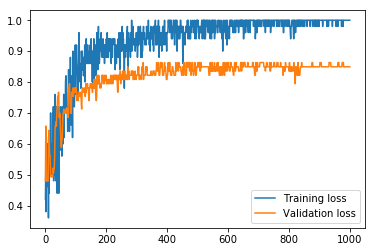

In [67]:
optimize(num_iterations=1000, X=250)

### **2.7. Wyniki**

In [68]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 12
    fig, axes = plt.subplots(4, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [69]:
def plot_confusion_matrix(data_pred_cls,data_predicted_cls):
    cm = confusion_matrix(y_true=data_pred_cls,
                          y_pred=data_predicted_cls)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

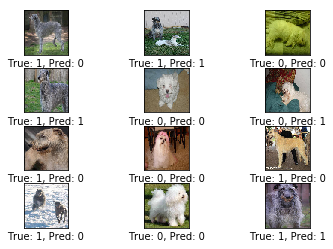

In [70]:
feed_dict_validation = {x: X_validation,
                    y_true: y_validation,
                    keep_prob_conv : 1,
                    keep_prob_fc : 1}
df_validation_Predicted_cls = session.run(y_pred_cls, feed_dict=feed_dict_validation)

plot_images(images=X_validation[50:62],
            cls_true=df_validation_toPred_cls[50:62],
            cls_pred=df_validation_Predicted_cls [50:62])

True : 1 / scottish_deerhound
Pred : 1 / scottish_deerhound


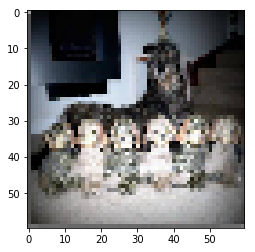

In [71]:
i = 63
print(("True : {0} / {1}").format(df_validation_toPred_cls[i], labels_name[df_validation_toPred_cls[i]]))
print(("Pred : {0} / {1}").format(df_validation_Predicted_cls[i], labels_name[df_validation_Predicted_cls[i]]))

lum = X_validation[i,:,:,:]
plt.imshow(lum)
plt.show()

[[33  5]
 [ 6 29]]


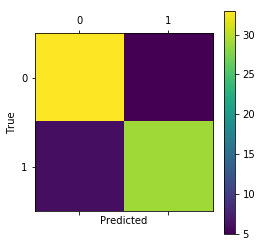

In [72]:
plot_confusion_matrix(df_validation_toPred_cls,df_validation_Predicted_cls)

### **2.8 Prezentacja wag**

In [73]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image],
                keep_prob_conv : 1,
                keep_prob_fc : 1}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [74]:
def plot_conv_weights(weights, input_channel):
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

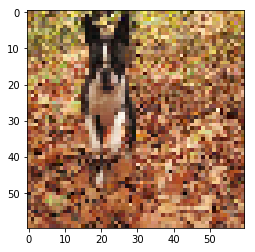

In [75]:
image1 = train[0,:,:,:]
plt.imshow(image1)
plt.show()

### **2.9. Wizalizacja warstw**

#### **2.9.1. Warstwa pierwsza**

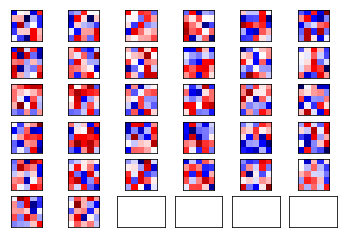

In [76]:
plot_conv_weights(weights=weights_conv1, input_channel = 0)

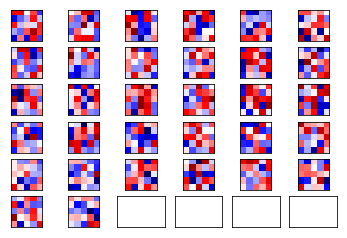

In [77]:
plot_conv_weights(weights=weights_conv1, input_channel = 1)

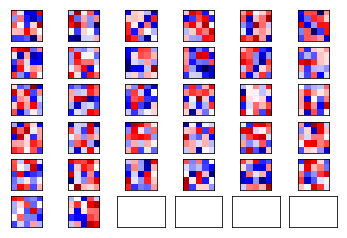

In [78]:
plot_conv_weights(weights=weights_conv1, input_channel = 2)

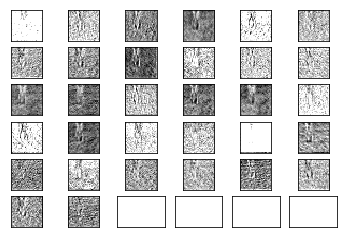

In [79]:
plot_conv_layer(layer=layer_conv1, image=image1)

#### **2.9.2. Warstwa druga**

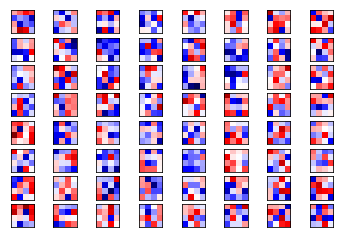

In [80]:
plot_conv_weights(weights=weights_conv2, input_channel = 0)

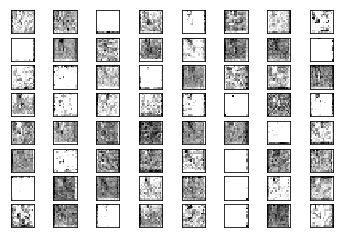

In [81]:
plot_conv_layer(layer=layer_conv2, image=image1)

#### **2.9.3. Warstwa trzecia**

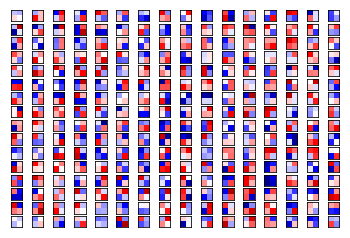

In [82]:
plot_conv_weights(weights=weights_conv3, input_channel = 1)

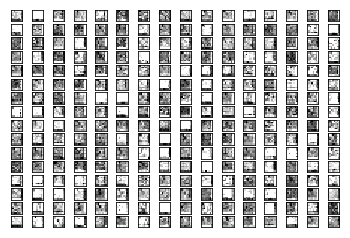

In [83]:
plot_conv_layer(layer=layer_conv3, image=image1)